### COMETH vs. HUB Skeleton: Matching skeleton kinematic chain
**Author:**  Shafagh Keyvanian [shkey@seas.upenn.edu]  
**Date**: *August 2024*

- COMETH: .osim modified (bsm_shkey.osim)  
- HUB: kinematic chain redesigned 
- Motive: angles extraction from quaternions modified

**COMETH**: Convex Optimization for Modelling, Estimating, and Tracking Humans  
nimblephysics  
Skeleton: bsm_shkey.osim (modified)

**HUB**: Human Upper Body  
Skeleton: kinematic chain defined in the code  

**Motive**: OptiTrack data  
Converting Motive exported .csv file to Euler_angles for Right/Left/Head chains  
Skeleton: Conventional Upper (27 Markers)

  

In [1]:
#%% import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from tf.transformations import quaternion_matrix, euler_from_matrix, euler_matrix

import nimblephysics as nimble
gui = nimble.NimbleGUI()
gui.serve(8080)

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080


192.168.1.1 - - [29/Oct/2024 12:05:32] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:30:48] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:35:41] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:37:39] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:38:53] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:46:55] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:54:46] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 11:58:37] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:06:32] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:27:55] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:31:57] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:36:33] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:38:59] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:44:34] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 12:54:51] "GET / HTTP/1.1" 200 -
192.168.1.1 - - [30/Oct/2024 13:12:25] "GET / HTTP/1.1" 200 -
192.168.

In [2]:
#%% Initialize HUB and COMETH data

# Define chains and DOFs
chain_R = ['Skeleton', 'Ab', 'Chest','RShoulder','RUArm','RFArm','RHand']
chain_L = ['Skeleton', 'Ab', 'Chest','LShoulder','LUArm','LFArm','LHand']
chain_H = ['Skeleton', 'Ab', 'Chest','Neck', 'Head']

HUB_dof_R = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation',   'Ab_bending', 'Ab_rotation', 'Ab_twist',    'Chest_bending', 'Chest_rotation', 'Chest_twist', \
             'RClavicle Protraction', 'RClavicle Elevation','RClavicle Axial Rotation',     'Shoulder Abduction', 'Shoulder Rotation', 'Shoulder Extension', \
             'Elbow Flexion', 'Elbow_0', 'Elbow Supination',    'Wrist Deviation', 'Wrist Supination', 'Wrist Flexion']

HUB_dof_L = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation',   'Ab_bending', 'Ab_rotation', 'Ab_twist',    'Chest_bending', 'Chest_rotation', 'Chest_twist', \
             'LClavicle Protraction', 'LClavicle Elevation', 'LClavicle Axial Rotation',    'Shoulder Abduction', 'Shoulder Rotation', 'Shoulder Extension', \
             'Elbow Flexion', 'Elbow_0', 'Elbow Supination',    'Wrist Deviation', 'Wrist Supination', 'Wrist Flexion']
             
HUB_dof_H = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation',   'Ab_bending', 'Ab_rotation', 'Ab_twist',    'Chest_bending', 'Chest_rotation', 'Chest_twist', \
             'Neck Bending', 'Neck Rotation', 'Neck Twist',     'Head Flexion', 'Head Rotation', 'Head Twist']

cometh_chain_R = ['ground_pelvis', 'lumbar', 'thoracic_spine','scapulothoracic_r','GlenoHumeral_r','elbow_r','wrist_r']
cometh_chain_L = ['ground_pelvis', 'lumbar', 'thoracic_spine','scapulothoracic_l','GlenoHumeral_l','elbow_l','wrist_l']
cometh_chain_H = ['ground_pelvis', 'lumbar', 'thoracic_spine','neck','head']
# cometh_chain_H = ['ground_pelvis', 'lumbar', 'thoracic_spine','neck','neck']

cometh_dof_R = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation','lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist', \
                'scapula_abduction_r', 'scapula_elevation_r', 'scapula_upward_rot_r', 'shoulder_r_z', 'shoulder_r_x', 'shoulder_r_y', \
                'elbow_flexion_r', 'elbow_0_r', 'pro_sup_r', 'wrist_flexion_r', 'wrist_0_r', 'wrist_deviation_r']

cometh_dof_L = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation','lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist', \
                'scapula_abduction_l', 'scapula_elevation_l', 'scapula_upward_rot_l', 'shoulder_l_x', 'shoulder_l_y', 'shoulder_l_z', \
                'elbow_flexion_l', 'elbow_0_l', 'pro_sup_l', 'wrist_flexion_l', 'wrist_0_l', 'wrist_deviation_l']
                    
cometh_dof_H = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation','lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist', \
                'neck_bending', 'neck_extension', 'neck_twist', 'head_bending', 'head_extension', 'head_twist']

# Load COMETH skeleton
# bsm_dir = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/bsm_original.osim'
# bsm_dir = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/bsm_10.osim'
# geom_dir = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/Geometry/'
# skeleton = nimble.biomechanics.OpenSimParser.parseOsim(bsm_dir, geom_dir).skeleton

# angles = [skeleton.getJoint(i).getDofName(j) for i in range(skeleton.getNumJoints()) for j in range(skeleton.getJoint(i).getNumDofs())]
# # [print(i, angles[i],round(skeleton.getPositions()[i]*180/np.pi, 2) ) for i in range(20, len(angles))]

# Load HUB skeleton
take = 'subject4_Rh_clinical'
csvfile = '../data/raw_exports/' + take + '.csv'
raw_data = pd.read_csv(csvfile, header=[3, 5, 6], index_col=0)
raw_data.rename(columns=lambda x: x.replace('Skeleton:', ''), level=0, inplace=True)
time = pd.read_csv(csvfile, header=6, usecols=[1]).values
skl_R, skl_L, skl_H = raw_data[chain_R].copy(), raw_data[chain_L].copy(), raw_data[chain_H].copy()
skl_R, skl_L, skl_H = skl_R.sort_index(axis=0), skl_L.sort_index(axis=0), skl_H.sort_index(axis=0)
# skl_L = skl_L.sort_index(axis=1)
# skl_H = skl_H.sort_index(axis=1)

# print(skl_R.columns)
# print(skl_R.index)

# Get HUB skeleton dimensions
t0 = 5000

# # Offset angle between strnm_dir_R/L and strnm_dir_H
def rotation_matrix_from_vectors(v1, v2):
    v1, v2 = v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)
    v = np.cross(v1, v2)
    c = np.dot(v1, v2)    
    V = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]]) #skew-symmetric cross-product matrix
    R = np.eye(3) + V + np.dot(V, V) * ((1 - c) / (1 + c))
    return R

def calc_sternum_offset(t=t0):
    strnm_dir_R = skl_R.loc[t, ('RShoulder', 'Position')] - skl_R.loc[t, ('Chest', 'Position')]
    strnm_dir_L = skl_L.loc[t, ('LShoulder', 'Position')] - skl_L.loc[t, ('Chest', 'Position')]
    strnm_dir_H = skl_H.loc[t, ('Neck', 'Position')] - skl_H.loc[t, ('Chest', 'Position')]
    strnm_ang_R = np.arccos(np.dot(strnm_dir_R, strnm_dir_H)/(np.linalg.norm(strnm_dir_R)*np.linalg.norm(strnm_dir_H)))
    strnm_ang_L = np.arccos(np.dot(strnm_dir_L, strnm_dir_H)/(np.linalg.norm(strnm_dir_L)*np.linalg.norm(strnm_dir_H)))
    # rotation matrix from strnm_dir_H to strnm_dir_R
    R_offset_r = rotation_matrix_from_vectors(strnm_dir_H, strnm_dir_R)
    L_offset_l = rotation_matrix_from_vectors(strnm_dir_H, strnm_dir_L)
    # print(strnm_dir_R, strnm_dir_L, strnm_dir_H)
    # R_offset_r = strnm_dir_H.flatten() @ strnm_dir_R
    # print(strnm_dir_H.shape, strnm_dir_R.shape, R_offset_r.shape)
    # L_offset_l = strnm_dir_H.flatten() @ strnm_dir_L
    return strnm_ang_R, strnm_ang_L, R_offset_r, L_offset_l


/tmp/ipykernel_435986/3944120578.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  q = skl[(chain[j], 'Rotation')].iloc[t]
/tmp/ipykernel_435986/3944120578.py:144: PerformanceWarning: indexing past lexsort depth may impact performance.
  pos = skl[(chain[j], 'Position')].iloc[t]
/tmp/ipykernel_435986/3589259695.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_R = skl_R.loc[t, ('RShoulder', 'Position')] - skl_R.loc[t, ('Chest', 'Position')]
/tmp/ipykernel_435986/3589259695.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_L = skl_L.loc[t, ('LShoulder', 'Position')] - skl_L.loc[t, ('Chest', 'Position')]
/tmp/ipykernel_435986/3589259695.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_H = skl_H.loc[t, ('Neck', 'Position')] - skl_H.loc[t, ('Chest', 'Position')]


Setting len to 0.04938
Setting neutral pos to 0
0
0
Setting len to 0.18068
Setting neutral pos to 0
0
0
Setting len to 0.2079
Setting neutral pos to 0
0
0
Setting len to 0.1174
Setting neutral pos to 0
0
0

CHAIN =         ['Skeleton', 'Ab', 'Chest', 'RShoulder', 'RUArm', 'RFArm', 'RHand']
ANGLES          COMETH                    HUB                      
Skeleton        [12.13 -6.71 87.22]       [-6.71 12.13 87.22]      
Ab              [-0.78 17.29 -2.63]       [-0.78 17.29 -2.63]      
Chest           [-4.86 -4.26 -2.15]       [-4.86 -4.26 -2.15]      
RShoulder       [-8.39 18.9  10.17]       [-8.39 18.9  10.17]      
RUArm           [-4.77  7.86  9.46]       [-4.77  7.86  9.46]      
RFArm           [121.04   0.   -28.94]    [121.04  -0.   -28.94]   
RHand           [ 4.21  0.   10.62]       [ 4.21 -1.54 10.62]      

POSITIONS       COMETH FK                 HUB FK                    Motive Positions         
Skeleton        [0. 0. 0.]                [0. 0. 0.]                [0

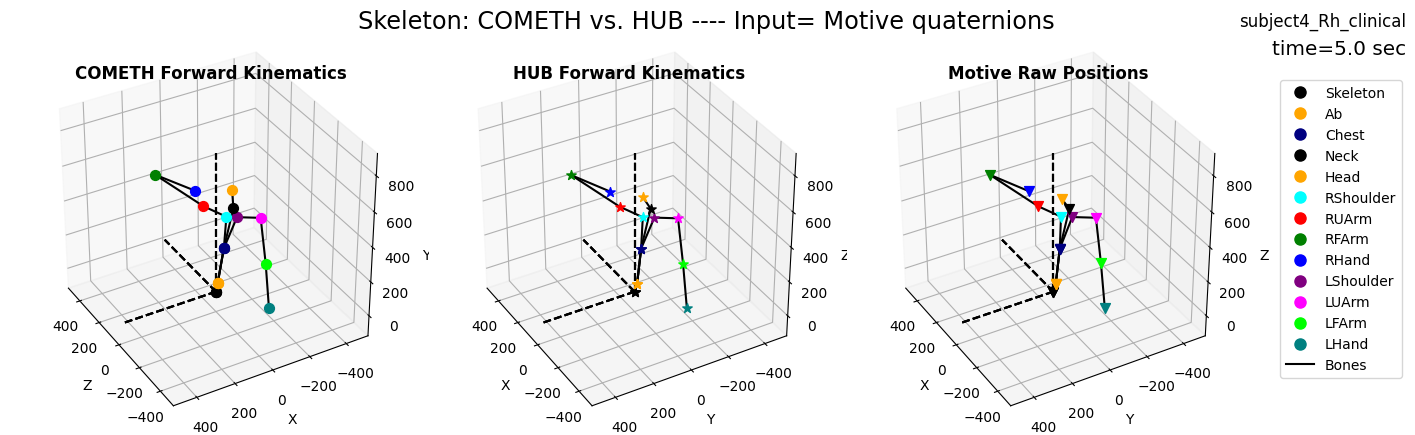

[2024-10-28 19:47:13] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-29 12:37:08] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-29 18:42:08] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-30 13:28:21] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-30 20:50:38] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-31 09:53:49] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are now 0 open connections.
[2024-10-31 10:39:47] [error] handle_read_frame error: websocketpp.transport:7 (End of File)
Connection closed.
There are no

In [4]:
# Set COMETH angles from Motive data

bsm_dir = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/bsm.osim'
geom_dir = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/Geometry/'
skeleton = nimble.biomechanics.OpenSimParser.parseOsim(bsm_dir, geom_dir).skeleton

# # bsm_dir_2 = '/home/shkey/catkins/human_model_ws/src/human_model/utils/COMETH/bsm_original.osim'
# # skeleton_2 = nimble.biomechanics.OpenSimParser.parseOsim(bsm_dir_2, geom_dir).skeleton
# # gui.nativeAPI().renderSkeleton(skeleton,layer='1', skeleton_2, layer='2')

angles = [skeleton.getJoint(i).getDofName(j) for i in range(skeleton.getNumJoints()) for j in range(skeleton.getJoint(i).getNumDofs())]
# [print(i, angles[i],round(skeleton.getPositions()[i]*180/np.pi, 2) ) for i in range(20, len(angles))]

scale = skeleton.getBodyScales()
# skeleton.setBodyScales(0.88*scale)

Motive = True

# Initialize Skeleton Angles
angles_init_base = [[0, 0, 0],    # 'pelvis_list', 'pelvis_tilt', 'pelvis_rotation'
                    [0, 0, 0],    # 'Ab_bending', 'Ab_extension', 'Ab_twist'
                    [0, 0, 0]]    # 'Chest_bending', 'Chest_extension', 'Chest_twist'

angles_init_L = np.vstack([angles_init_base,
                   [[0, 0, 0],    # Clavicle (Protraction, Elevation, Rotation) --- scapulothoracic (abduction, elevation, upward_rot)
                    [0, 0, 0],    # Shoulder (Abduction, Extension, Rotation)   --- GlenoHumeral (shoulder_z, shoulder_x, shoulder_y)
                    [0, 0, 0],    # Elbow (Flexion, 0, Supination) --- elbow (elbow_flexion, pro_sup)
                    [0, 0, 0]]])  # Wrist (Flexion, 0, Deviation)  --- wrist (wrist_flexion, wrist_deviation) 

angles_init_H = np.vstack([angles_init_base,
                   [[0, 0, 0],    # 'Neck Bending', 'Neck Rotation', 'Neck Twist'   
                    [0, 0, 0]]])  # 'Head Bending', 'Head Rotation', 'Head Twist'

angles_init_R = angles_init_L

def get_euler_HUB(chain, t=t0): 
    skl = skl_R if chain==chain_R else skl_L if chain==chain_L else skl_H
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain)):
        q = skl[(chain[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        if chain==chain_H:
            eul_sequnce = 'ryxz'
        else:
            eul_sequnce = 'ryxz' if j < 3 else 'rzyx'
        eul_values = euler_from_matrix(R_rel, axes=eul_sequnce)

        if chain==chain_R and j>2:
            eul_values = [eul_values[0], -eul_values[1], eul_values[2]]

        if chain==chain_L and j>2:
            # eul_values = [-eul_values[0], -eul_values[1], eul_values[2]]
            eul_values = [-eul_values[0], eul_values[1], eul_values[2]]
            
        eul.append(eul_values)
    return np.array(eul)

def get_skl_angles(chain, t=t0):
    if Motive:
        HUB_angles = get_euler_HUB(chain, t)
    else:
        HUB_angles = angles_init_R if chain==chain_R else angles_init_L if chain==chain_L else angles_init_H
        HUB_angles = np.array(HUB_angles) * np.pi/180
    return HUB_angles

def set_COMETH_skeleton_angles(skeleton, layer='1', skl_loc=[0, 0, 0]):
    p = skeleton.getPositions().copy()
    
    angles = [skeleton.getJoint(i).getDofName(j) for i in range(skeleton.getNumJoints()) for j in range(skeleton.getJoint(i).getNumDofs())]
    for i in range(len(angles)):
            p[i] = 0

    angles_HUB_R, angles_HUB_L, angles_HUB_H = get_skl_angles(chain_R), get_skl_angles(chain_L), get_skl_angles(chain_H)

    p[3:6]   = skl_loc                        # pelvis_tx, pelvis_ty, pelvis_tz
    
    p[0:3]   = angles_HUB_H[0]                # pelvis_list, pelvis_tilt, pelvis_rotation
    p[20:23] = angles_HUB_H[1]                # lumbar_bedning, lumbar_extension, lumbar_twist
    p[23:26] = angles_HUB_H[2]                # thorax_bending, thorax_extension, thorax_twist
    # p[26:29] = angles_HUB_H[3]                # neck_bending, neck_extension, neck_twist
    # p[29:32] = angles_HUB_H[4]                # head_bending, head_extension, head_twist
    p[29:32] = angles_HUB_H[3]                # head_bending, head_extension, head_twist
    
    p[32:35] = angles_HUB_R[3]                # scapulothoracic_r (abduction, elevation, upward_rot)
    p[35:38] = angles_HUB_R[4]                # GlenoHumeral_r (shoulder_r_z, shoulder_r_x, shoulder_r_y)
    p[38:40] = angles_HUB_R[5,[0,2]]          # elbow_r (elbow_flexion, pro_sup)
    p[40:42] = angles_HUB_R[6,[0,2]]          # wrist_r (wrist_flexion, wrist_deviation)

    p[42:45] = angles_HUB_L[3]                # scapulothoracic_l (abduction, elevation, upward_rot)
    p[45:48] = angles_HUB_L[4]                # GlenoHumeral_l (shoulder_l_x, shoulder_l_y, shoulder_l_z)
    p[48:50] = angles_HUB_L[5,[0,2]]          # elbow_l (elbow_flexion, pro_sup)
    p[50:52] = angles_HUB_L[6,[0,2]]          # wrist_l (wrist_flexion, wrist_deviation)

    # p[29:32] = angles_HUB_R[3]                # scapulothoracic_r (abduction, elevation, upward_rot)
    # p[32:35] = angles_HUB_R[4]                # GlenoHumeral_r (shoulder_r_z, shoulder_r_x, shoulder_r_y)
    # p[35:37] = angles_HUB_R[5,[0,2]]          # elbow_r (elbow_flexion, pro_sup)
    # p[37:39] = angles_HUB_R[6,[0,2]]          # wrist_r (wrist_flexion, wrist_deviation)
    
    # p[39:42] = angles_HUB_L[3]                # scapulothoracic_l (abduction, elevation, upward_rot)
    # p[42:45] = angles_HUB_L[4]                # GlenoHumeral_l (shoulder_l_x, shoulder_l_y, shoulder_l_z)
    # p[45:47] = angles_HUB_L[5,[0,2]]          # elbow_l (elbow_flexion, pro_sup)
    # p[47:49] = angles_HUB_L[6,[0,2]]          # wrist_l (wrist_flexion, wrist_deviation)

    skeleton.setPositions(p)
    gui.nativeAPI().renderSkeleton(skeleton,layer=layer)

    joint_positions = skeleton.getJointWorldPositionsMap()
    # print(joint_positions)

    for i in range(skeleton.getNumBodyNodes()):
        T_i = skeleton.getBodyNode(i).getWorldTransform()
        gui.nativeAPI().renderBasis(scale=0.05, pos=T_i.translation(), euler=nimble.math.matrixToEulerXYZ(T_i.rotation()), prefix='basis'+skeleton.getBodyNode(i).getName())

    for cometh_chain in [cometh_chain_R, cometh_chain_L, cometh_chain_H]:
        color = [0,255,0,0.8] if cometh_chain==cometh_chain_H else [0,0,0,1] if cometh_chain==cometh_chain_R else [0,0,255,1]
        for i, joint in enumerate(cometh_chain):
            # print(i, cometh_chain[i], joint_positions[cometh_chain[i]])
            # T_i = skeleton.getBodyNode(i).getWorldTransform()
            # gui.nativeAPI().renderBasis(scale=0.05, pos=T_i.translation(), euler=nimble.math.matrixToEulerXYZ(T_i.rotation()), prefix='basis'+skeleton.getBodyNode(i).getName())
            gui.nativeAPI().createSphere(key=joint, radii=np.array([0.01,0.01,0.01]), pos=joint_positions[joint], color=np.array(color))
    
    # gui.nativeAPI().createSphere(key='neck', radii=np.array([0.01,0.03,0.01]), pos=joint_positions['neck'], color=np.array([0,0,0,1]))
    # midhip_pos = (joint_positions['hip_l']+joint_positions['hip_r'])/2
    # gui.nativeAPI().createSphere(key='midhip', radii=np.array([0.01,0.01,0.01]), pos=midhip_pos, color=np.array([100,0,200,1]))
    gui.nativeAPI().createSphere(key='hip_r', radii=np.array([0.01,0.01,0.01]), pos=joint_positions['hip_r'], color=np.array([0,0,0,1]))
    gui.nativeAPI().createSphere(key='hip_l', radii=np.array([0.01,0.01,0.01]), pos=joint_positions['hip_l'], color=np.array([0,0,255,1]))
    gui.nativeAPI().createBox(key='ground', size=np.array([0.02,0.02,0.02]), color=np.array([0,0,200,1]))

def get_angles_COMETH(chain):
    cometh_dof = cometh_dof_R if chain==chain_R else cometh_dof_L if chain==chain_L else cometh_dof_H
    cometh_angles = np.zeros(len(cometh_dof))
    for i in range(len(cometh_dof)):
        if cometh_dof[i] in angles:
            cometh_angles[i] = skeleton.getPositions()[angles.index(cometh_dof[i])]
    return cometh_angles.reshape(-1, 3)

def get_pos_HUB_raw(chain, t=t0):  
    skl = skl_R if chain==chain_R else skl_L if chain==chain_L else skl_H
    positions = []
    for j in range(len(chain)):
        pos = skl[(chain[j], 'Position')].iloc[t]
        positions.append(np.array(pos))
    positions -= positions[0]
    return positions  

def get_pos_HUB_FK(chain, t=t0): 
    positions = get_pos_HUB_raw(chain, t)
    bone_length = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    # print('bone_length = ', bone_length)
    # bone_length = np.append(bone_length, 0.1)

    eul_angles = get_skl_angles(chain, t)  
    strnm_ang_R, strnm_ang_L, R_offset_r, R_offset_l = calc_sternum_offset(t)  

    fk_pose = np.zeros((len(eul_angles), 3))
    pos_prox = np.zeros(3)
    R_prox = np.eye(3)
    for i in range(3):
        R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes='ryxz')[:3, :3]
        R_prox = R_prox @ R_rel
        if i==2:
            offset_ang = strnm_ang_R if chain==chain_R else -strnm_ang_L if chain==chain_L else 0
            R_off = euler_matrix(0, 0, offset_ang, axes='rzxy')[:3, :3]
            pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
            # R_off = R_offset_r if chain==chain_R else R_offset_l if chain==chain_L else np.eye(3)
            # pos_prox += R_off @ R_prox @ np.array([0, 0, bone_length[i]])
        else:
            pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox
    for i in range(3, len(eul_angles)-1):
        if chain==chain_R:  
            # R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes='rzyx')[:3, :3]
            R_rel = euler_matrix(eul_angles[i, 0], -eul_angles[i, 1], eul_angles[i, 2], axes='rzyx')[:3, :3]
            R_prox = R_prox @ R_rel
            pos_prox += R_prox @ np.array([bone_length[i], 0, 0])
        elif chain==chain_L:
            # R_rel = euler_matrix(-eul_angles[i, 0], -eul_angles[i, 1], eul_angles[i, 2], axes='rzyx')[:3, :3]
            R_rel = euler_matrix(-eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes='rzyx')[:3, :3]
            R_prox = R_prox @ R_rel
            pos_prox += R_prox @ np.array([-bone_length[i], 0, 0])
        elif chain==chain_H:
            R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes='ryxz')[:3, :3]
            R_prox = R_prox @ R_rel
            pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox
    return fk_pose

def get_pos_COMETH_FK(chain):
    cometh_chain = cometh_chain_R if chain==chain_R else cometh_chain_L if chain==chain_L else cometh_chain_H
    joint_positions = skeleton.getJointWorldPositionsMap()
    joint_positions_chain = []
    R0 = euler_matrix(0, np.pi/2, np.pi/2, axes='rxyz')[:3, :3] # R0 = [[0,0,1], [1,0,0], [0,1,0]]
    midhip_pos = R0 @ (joint_positions['hip_l']+joint_positions['hip_r'])/2 * 1000
    # joint_positions_chain.append(R0 @ midhip_pos)
    for i in range(len(cometh_chain)):
        joint_positions_rot = R0 @ joint_positions[cometh_chain[i]]
        joint_positions_chain.append(joint_positions_rot)
    joint_positions_chain = np.array(joint_positions_chain) * 1000
    # joint_positions_chain -= joint_positions_chain[0]
    # joint_positions_chain -= midhip_pos
    # if chain==chain_H:
    #     joint_positions_chain = np.vstack([np.zeros(3), joint_positions_chain])
    return joint_positions_chain 

def show_joint_positions(method='HUB_raw'):
    for chain in [chain_R, chain_L, chain_H]:
        color = [0,255,0,0.3] if chain==chain_H else [0,0,0,0.3] if chain==chain_R else [0,0,255,0.3]
        joint_positions = get_pos_HUB_raw(chain) if method=='HUB_raw' else get_pos_HUB_FK(chain) if method=='HUB_FK' else get_pos_COMETH_FK(cometh_chain)
        R0 = euler_matrix(0, np.pi/2, np.pi/2, axes='rxyz')[:3, :3]
        for j, joint in enumerate(chain):
            joint_pos = R0.T@joint_positions[j] / 1000
            gui.nativeAPI().createSphere(key=joint, radii=np.array([0.02,0.02,0.02]), pos=joint_pos, color=np.array(color))

def print_joint_properties(chain, angles=True, positions=True):
    print("\nCHAIN =        ", chain)
    if angles:
        print("{:<15} {:<25} {:<25}".format("ANGLES", "COMETH", "HUB"))
        for i in range(len(chain)):
            print("{:<15} {:<25} {:<25}".format(chain[i], str(np.around(get_angles_COMETH(chain)[i] *180/np.pi, 2)), str(np.around(get_skl_angles(chain)[i] *180/np.pi, 2))) )
    if positions:
        print("\n{:<15} {:<25} {:<25} {:<25}".format("POSITIONS", "COMETH FK", "HUB FK", "Motive Positions"))
        for i in range(len(chain)):
            if Motive:
                print("{:<15} {:<25} {:<25} {:<25}".format(chain[i], str(np.around(get_pos_COMETH_FK(chain)[i], 2)), str(np.around(get_pos_HUB_FK(chain)[i], 2)), str(np.around(get_pos_HUB_raw(chain)[i], 2))) )
            else:
                print("{:<15} {:<25} {:<25}".format(chain[i], str(np.around(get_pos_COMETH_FK(chain)[i], 2)), str(np.around(get_pos_HUB_FK(chain)[i], 2))) )

def visualize_joint_locations(Motive):   
    colors_R = ['black', 'orange', 'navy', 'cyan', 'red', 'green', 'blue']
    colors_L = ['black', 'orange', 'navy', 'purple', 'magenta', 'lime', 'teal']
    colors_H = ['black', 'orange', 'navy', 'black', 'orange']

    n_ax = 3 if Motive else 2       # COMETH, HUB, Raw
    input = 'Motive quaternions' if Motive else 'User-defined Angles'
    fig_title = 'Skeleton: COMETH vs. HUB ---- Input= {}'.format(input)  
    ax_title = ['COMETH Forward Kinematics', 'HUB Forward Kinematics', 'Motive Raw Positions']
    joint_marker = ['o', '*', 'v'] 

    fig, axes = plt.subplots(1, n_ax, subplot_kw={'projection': '3d'}, figsize=(n_ax*5-1, 4), constrained_layout=True, num='Skeleton Visualization')
    fig.suptitle(fig_title, fontsize='xx-large', y=1.05)#, fontweight='bold')
    for chain in [chain_R, chain_L, chain_H]:
        joint_colors = colors_R if chain==chain_R else colors_L if chain==chain_L else colors_H
        
        pos_COM, pos_HUB, pos_raw = get_pos_COMETH_FK(chain), get_pos_HUB_FK(chain), get_pos_HUB_raw(chain)
        # if chain==chain_H:
        #     pos_COM = np.vstack([np.zeros(3), pos_COM])

        pos = [pos_COM, pos_HUB, pos_raw] if Motive else [pos_COM, pos_HUB]
        
        for i in range(n_ax):
            axes[i].set_title(ax_title[i], fontsize='large', pad=30, fontweight='bold')
            # axes[i].view_init(elev=25, azim=160)
            axes[i].view_init(elev=35, azim=150)
            axes[i].set(xlabel='X', ylabel='Y', zlabel='Z', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
            axes[i].plot([0, 0], [0, 0], [0, 800], 'k--')
            axes[i].plot([0, 0], [0, 500], [0, 0], 'k--')
            axes[i].plot([0, 500], [0, 0], [0, 0], 'k--')
            for j in range(len(chain)):
                axes[i].scatter(pos[i][j][0], pos[i][j][1], pos[i][j][2], marker=joint_marker[i], s=50, color=joint_colors[j])
                if j!=0:
                    axes[i].plot([pos[i][j][0], pos[i][j-1][0]], [pos[i][j][1], pos[i][j-1][1]], [pos[i][j][2], pos[i][j-1][2]], 'k')

    axes[0].set(xlabel='Z', ylabel='X', zlabel='Y', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
    axes[-1].legend(handles=
        [Line2D([],[], color=colors_H[j], linestyle='', marker='o', markersize=8, label=f"{chain_H[j]}") for j in range(len(chain_H))] +
        [Line2D([],[], color=colors_R[j], linestyle='', marker='o', markersize=8, label=f"{chain_R[j]}") for j in range(3, len(chain_R))] + 
        [Line2D([],[], color=colors_L[j], linestyle='', marker='o', markersize=8, label=f"{chain_L[j]}") for j in range(3, len(chain_L))] + 
        [Line2D([],[], color='black', linestyle='-', label='Bones')],  loc='right', bbox_to_anchor=(1.4, 0.5))

    datetime = pd.Timestamp.now().strftime('%m%d_%H%M')
    if Motive:
        fig.text(1, 1.02, '{}'.format(take), ha='right', va='center', fontsize='large')
        fig.text(1, 0.95, 'time={} sec'.format(t0/1000), ha='right', va='center', fontsize='x-large')#, fontweight='bold')
        # fig.savefig('../figures/HUB_COMETH_comparison/Motive_{}_{}_{}.png'.format(t, take, datetime), dpi=300, bbox_inches='tight')
        fig.savefig('../figures/HUB_COMETH_comparison/Motive_{}_{}.png'.format(t0, take), dpi=300, bbox_inches='tight')
    else:
        # fig.savefig('../figures/HUB_COMETH_comparison/UserDefined_{}.png'.format(datetime), dpi=300, bbox_inches='tight')
        fig.savefig('../figures/HUB_COMETH_comparison/UserDefined.png', dpi=300, bbox_inches='tight')

set_COMETH_skeleton_angles(skeleton)
show_joint_positions(method='HUB_FK')
visualize_joint_locations(Motive)

# print_joint_properties(chain_H, angles=True, positions=True)
print_joint_properties(chain_R, angles=True, positions=True)
# print_joint_properties(chain_L, angles=False, positions=True)

# set_COMETH_skeleton_angles(skeleton_2, layer='2', skl_loc=[0, 0, 0.5])
